In [1]:
!pip install tntorch

  Using cached tntorch-1.1.2-py3-none-any.whl.metadata (998 bytes)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached tntorch-1.1.2-py3-none-any.whl (63 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [2]:
pip install --upgrade pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 493.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 31.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torch

# Quantum Algorithm as a PDE Solver for Computational Fluid Dynamics (CFD)

### The code below solves the Hydroynamic Schrödinger Equation

Precomputing classical Burgers trajectory for comparison...
Done precomputing classical trajectory.
---- RESOURCE ESTIMATE ----
Qubits required: 8
Estimated two-qubit gate depth (approx): 21
Note: this is a crude estimate; gate counts depend on transpilation & mapping.
----------------------------
Step 0: Burgers Residual (first 5 values): [-4.82892627 -2.43836726 -0.02291041  0.01567883 -0.00837903]
------------------------------------------------------------------------------------------------------------------------
Step 0: Velocity Gradient (first 5 values): [ 1.54819944  1.55224976  1.57351143  0.00994747 -1.5706118 ]
------------------------------------------------------------------------------------------------------------------------
Step 0: Mean squared residual: 3.1833748536150743
------------------------------------------------------------------------------------------------------------------------

--- Madelung Equation with a = 1.0, m = 1.0 (ℏ = 1) ---
             d      

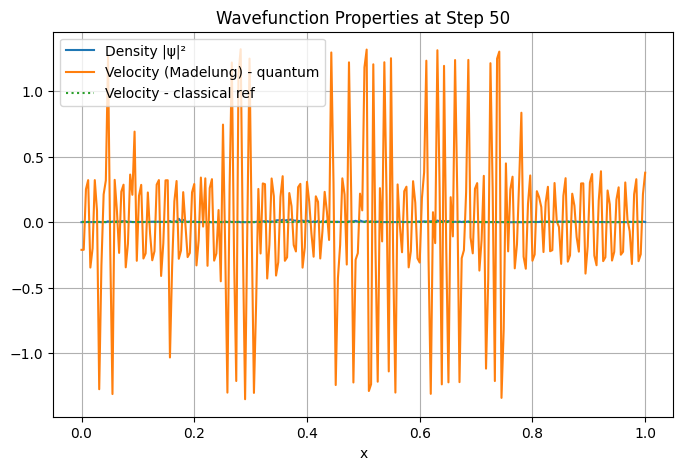

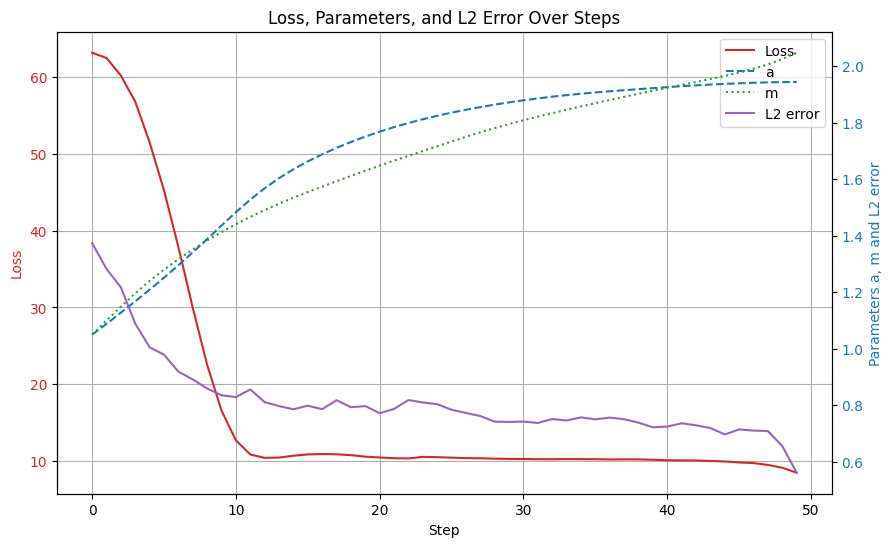

------------------------------------------------------------------------------------------------------------------------
Optimization complete!
Final a: 1.944466, Final m: 2.048343
Saved detailed history to: run_outputs/optimization_history.csv
Saved summary stats to: run_outputs/summary_stats.csv
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Step 0: Burgers Residual (first 5 values): [ 0.00000000e+00 -0.00000000e+00  1.23370055e+16 -2.46740110e+16
  1.23370055e+16]
------------------------------------------------------------------------------------------------------------------------
Step 0: Velocity Gradient (first 5 values): [ 0.00000000e+00 -7.85398163e+07 -7.85398163e+07  1.57079633e+08
  7.85398163e+07]
-------------------------------------------------------------------------------------

In [6]:
# Import PennyLane for quantum computing
# This library provides tools for quantum circuit simulation and automatic differentiation
import pennylane as qml

# Import NumPy for numerical operations
# Used for arrays, linear algebra, random number generation, etc.
import numpy as np

# Import matplotlib for plotting
# Used for visualizing results with plots
import matplotlib.pyplot as plt

# Import sympy for symbolic math printing
# Useful for displaying equations symbolically
import sympy as sp

# Import time and csv for timing and saving outputs
import time
import csv
import os

# Number of qubits = number of spatial discretization points
# Defines size of the quantum system
Nx = 8

# Number of layers in the ansatz circuit
# Determines depth/complexity of the quantum circuit
layers = 3

# Create quantum device simulator with Nx qubits
# This initializes a classical simulator for quantum circuits with Nx qubits
dev = qml.device("default.qubit", wires=Nx)

# ----------------------------
# Target wavefunction (Gaussian)
# ----------------------------
def target_wavefunction(Nx):
    """Return a normalized Gaussian wavefunction over 2^Nx basis states."""
    num_states = 2**Nx
    x_points = np.linspace(0, 1, num_states)
    x0 = 0.5
    sigma = 0.1
    amplitudes = np.exp(- (x_points - x0)**2 / (2 * sigma**2))
    psi0 = amplitudes / np.linalg.norm(amplitudes)
    return psi0

# Store the target wavefunction as a PennyLane numpy array (no gradient required)
target_psi = qml.numpy.array(target_wavefunction(Nx), requires_grad=False)

# ----------------------------
# Quantum ansatz and qnode
# ----------------------------
def layered_schrodinger_ansatz(params, a, m):
    """Parameterized ansatz: RY(a*param) and RZ(m*param) per qubit, then CNOT chain."""
    for layer in range(layers):
        for i in range(Nx):
            qml.RY(a * params[layer, i, 0], wires=i)
            qml.RZ(m * params[layer, i, 1], wires=i)
        for i in range(Nx - 1):
            qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def wavefunction_qnode(params, a, m):
    """Return full statevector after ansatz."""
    layered_schrodinger_ansatz(params, a, m)
    return qml.state()

# ----------------------------
# Madelung transform, losses
# ----------------------------
def madelung_from_state(state, m=1.0):
    """Return density rho and velocity v from complex state via Madelung transform."""
    psi = state
    rho = qml.math.abs(psi)**2
    phase = qml.math.angle(psi)
    dphase_dx = qml.math.gradient(phase)
    safe_m = m if abs(qml.math.toarray(m).item()) > 1e-8 else 1e-8
    v = dphase_dx / safe_m
    return rho, v

def fidelity(state1, state2):
    """Squared overlap fidelity between two states."""
    overlap = qml.math.sum(qml.math.conj(state1) * state2)
    return qml.math.abs(overlap)**2

def burgers_residual(v):
    """Mean squared Burgers residual from velocity field (v * dv/dx)."""
    dv_dx = qml.math.gradient(v)
    residual = v * dv_dx
    return qml.math.mean(residual**2)

def boundary_penalty(state):
    """Simple boundary penalty (|psi(0)|^2 + |psi(L)|^2)."""
    penalty = qml.math.abs(state[0])**2 + qml.math.abs(state[-1])**2
    return penalty

# ----------------------------
# Debugging, printing helpers
# ----------------------------
global_step = 0

def print_madelung_equation(a_val, m_val):
    """Print symbolic Madelung equation with given a,m (for presentation/debug)."""
    rho, v, P, t, hbar = sp.symbols('rho v P t hbar')
    laplacian = sp.Function('∇²')
    gradient = sp.Function('∇')
    quantum_potential_coeff = (hbar**2) / (4 * m_val)
    quantum_potential = quantum_potential_coeff * laplacian(sp.log(rho))
    lhs = rho * sp.Derivative(v, t) + sp.Symbol('(v ⋅ ∇)v')
    rhs = -gradient(P + quantum_potential)
    eq = sp.Eq(lhs, rhs)
    eq = eq.subs(hbar, 1)
    print("\n--- Madelung Equation with a = {}, m = {} (ℏ = 1) ---".format(a_val, m_val))
    sp.pprint(eq, use_unicode=True)
    print("------------------------------------------------------------------------------------------------------------------------\n")

def loss_fn(params, a, m, alpha=10, beta=50):
    """Total loss combining Burgers residual + fidelity penalty + boundary penalty."""
    global global_step

    if abs(qml.math.toarray(m).item()) < 1e-7:
        print("Warning: m is near zero, using safe epsilon")
        print("------------------------------------------------------------------------------------------------------------------------")

    state = wavefunction_qnode(params, a, m)
    rho, v = madelung_from_state(state, m)
    dv_dx = qml.math.gradient(v)
    residual = v * dv_dx

    if global_step % 10 == 0:
        print(f"Step {global_step}: Burgers Residual (first 5 values): {qml.math.toarray(residual)[:5]}")
        print("------------------------------------------------------------------------------------------------------------------------")
        print(f"Step {global_step}: Velocity Gradient (first 5 values): {qml.math.toarray(dv_dx)[:5]}")
        print("------------------------------------------------------------------------------------------------------------------------")
        print(f"Step {global_step}: Mean squared residual: {qml.math.toarray(qml.math.mean(residual**2))}")
        print("------------------------------------------------------------------------------------------------------------------------")

    if global_step == 0:
        a_val = qml.math.toarray(a).item()
        m_val = qml.math.toarray(m).item()
        print_madelung_equation(a_val, m_val)
        print(f"Numeric values at step 0 for a={a_val}, m={m_val}:")
        print("------------------------------------------------------------------------------------------------------------------------")
        print(f"Density (first 5): {qml.math.toarray(rho)[:5]}")
        print("------------------------------------------------------------------------------------------------------------------------")
        print(f"Velocity (first 5): {qml.math.toarray(v)[:5]}")
        print("------------------------------------------------------------------------------------------------------------------------")
        print(f"Burgers Residual (first 5): {qml.math.toarray(residual)[:5]}")
        print("------------------------------------------------------------------------------------------------------------------------")

    global_step += 1

    burgers_loss = burgers_residual(v)
    fidelity_loss = 1 - fidelity(state, target_psi)
    boundary_loss = boundary_penalty(state)
    total_loss = burgers_loss + alpha * fidelity_loss + beta * boundary_loss
    return total_loss

# ----------------------------
# Classical Burgers solver (finite difference) for reference
# ----------------------------
def classical_burgers(u0, dx, dt, nu, steps, periodic=True):
    """
    Simple explicit scheme for viscous Burgers:
    u^{n+1}_i = u^n_i - dt * u_i * (u_{i} - u_{i-1})/dx + nu * dt * (u_{i+1} - 2 u_i + u_{i-1})/dx^2
    This is a simple, not-fully-stable scheme; chosen for clarity and short-time integration.
    """
    u = u0.copy()
    traj = [u.copy()]
    N = len(u0)
    for n in range(steps):
        u_next = np.zeros_like(u)
        for i in range(N):
            im = (i-1) % N if periodic else max(i-1, 0)
            ip = (i+1) % N if periodic else min(i+1, N-1)
            adv = u[i] * (u[i] - u[im]) / dx
            diff = nu * (u[ip] - 2*u[i] + u[im]) / (dx*dx)
            u_next[i] = u[i] - dt * adv + dt * diff
        u = u_next
        traj.append(u.copy())
    return np.array(traj)  # shape (steps+1, N)

# ----------------------------
# Resource estimate helper (very rough)
# ----------------------------
def resource_estimate(Nx, layers):
    """Print a quick resource estimate: qubits, two-qubit gate depth (rough)."""
    qubits = Nx
    # crude two-qubit depth estimate = layers * (Nx-1) (one CNOT chain per layer)
    two_qubit_depth = layers * (Nx - 1)
    print("---- RESOURCE ESTIMATE ----")
    print(f"Qubits required: {qubits}")
    print(f"Estimated two-qubit gate depth (approx): {two_qubit_depth}")
    print("Note: this is a crude estimate; gate counts depend on transpilation & mapping.")
    print("----------------------------")

# ----------------------------
# Setup, initial params, optimizer
# ----------------------------
np.random.seed(42)
params = 0.01 * np.random.randn(layers, Nx, 2)
params = qml.numpy.array(params, requires_grad=True)

a_param = qml.numpy.array(1.0, requires_grad=True)
m_param = qml.numpy.array(1.0, requires_grad=True)

opt = qml.AdamOptimizer(stepsize=0.05)

loss_history = []
a_history = []
m_history = []
l2_history = []
time_history = []

num_steps = 50
plotting_x_points = np.linspace(0, 1, 2**Nx)

# ----------------------------
# Precompute classical reference trajectory
# ----------------------------
# Build initial classical velocity from the target wavefunction phase (m=1)
# This tries to set classical initial condition to the same physical velocity used in the Madelung transform.
psi_target = np.array(target_psi)
phase_target = np.angle(psi_target)
dx = 1.0 / (len(phase_target) - 1) if len(phase_target) > 1 else 1.0
# safe initial mass for reference (use m=1)
safe_m0 = 1.0
u0 = np.gradient(phase_target) / safe_m0  # initial velocity for classical solver
# classical solver parameters (choose dt consistent with dx for stability)
dt = 0.001
nu = 0.001  # small viscosity
print("Precomputing classical Burgers trajectory for comparison...")
classical_traj = classical_burgers(u0, dx=dx, dt=dt, nu=nu, steps=num_steps, periodic=True)
# classical_traj has shape (num_steps+1, N); we'll compare step n to classical_traj[n]
print("Done precomputing classical trajectory.")

# Save CSV header
out_dir = "run_outputs"
os.makedirs(out_dir, exist_ok=True)
csv_path = os.path.join(out_dir, "optimization_history.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["step", "loss", "a", "m", "L2_error", "step_time_seconds"])

# Print resource estimate to help Algorithm Design Brief
resource_estimate(Nx, layers)

# ----------------------------
# Interactive plotting setup
# ----------------------------
plt.ion()
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# ----------------------------
# Optimization loop
# ----------------------------
for step in range(num_steps):
    old_a = qml.math.toarray(a_param).item()
    old_m = qml.math.toarray(m_param).item()

    def cost(p, a_, m_):
        return loss_fn(p, a_, m_)

    t0 = time.time()
    (params, a_param, m_param), curr_loss = opt.step_and_cost(cost, params, a_param, m_param)
    step_time = time.time() - t0

    new_a = qml.math.toarray(a_param).item()
    new_m = qml.math.toarray(m_param).item()

    # Get quantum-derived velocity
    state = wavefunction_qnode(params, a_param, m_param)
    rho, v_q = madelung_from_state(state, m_param)
    v_q_arr = qml.math.toarray(v_q)

    # Compare with classical reference (use index 'step' from precomputed traj)
    # If classical time-step differs, we still compare using index-matching for demonstration.
    u_ref = classical_traj[min(step, classical_traj.shape[0]-1)]
    # L2 error (discrete)
    l2 = np.linalg.norm(v_q_arr - u_ref) / np.sqrt(len(u_ref))

    # store histories
    loss_history.append(qml.math.toarray(curr_loss).item())
    a_history.append(new_a)
    m_history.append(new_m)
    l2_history.append(l2)
    time_history.append(step_time)

    # Print with step-divider and delta formatting
    print(f"Step {step + 1:02d}: Loss={curr_loss:.6f}, a: {old_a:.6f} -> {new_a:.6f}, m: {old_m:.6f} -> {new_m:.6f}")
    print(f"  Step runtime (s): {step_time:.4f}, L2 error vs classical: {l2:.6f}")
    print("------------------------------------------------------------------------------------------------------------------------")

    # Append to CSV
    with open(csv_path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([step+1, float(qml.math.toarray(curr_loss).item()), new_a, new_m, float(l2), float(step_time)])

    # Update live plot (density + velocity)
    axs.cla()
    axs.plot(plotting_x_points, qml.math.toarray(rho), label='Density |ψ|²')
    axs.plot(plotting_x_points, v_q_arr, label='Velocity (Madelung) - quantum')
    axs.plot(plotting_x_points, u_ref, label='Velocity - classical ref', linestyle='dotted')
    axs.set_title(f'Wavefunction Properties at Step {step + 1}')
    axs.set_xlabel('x')
    axs.legend()
    axs.grid(True)
    fig.canvas.draw()
    fig.canvas.flush_events()

# ----------------------------
# Final plots: Loss + parameters + L2 error
# ----------------------------
plt.ioff()

plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax1.plot(loss_history, color='tab:red', label='Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(a_history, color='tab:blue', linestyle='--', label='a')
ax2.plot(m_history, color='tab:green', linestyle=':', label='m')
ax2.plot(l2_history, color='tab:purple', linestyle='-', label='L2 error')
ax2.set_ylabel('Parameters a, m and L2 error', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title("Loss, Parameters, and L2 Error Over Steps")
plt.show()

# Save aggregated CSV summary
summary_csv = os.path.join(out_dir, "summary_stats.csv")
with open(summary_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["final_loss", "final_a", "final_m", "mean_L2_error", "total_time_seconds"])
    writer.writerow([loss_history[-1], a_history[-1], m_history[-1], np.mean(l2_history), np.sum(time_history)])

# Print completion message
print("------------------------------------------------------------------------------------------------------------------------")
print("Optimization complete!")
print(f"Final a: {a_param:.6f}, Final m: {m_param:.6f}")
print(f"Saved detailed history to: {csv_path}")
print(f"Saved summary stats to: {summary_csv}")
print("------------------------------------------------------------------------------------------------------------------------")

# Run comparison with fixed (a,m)=(1,0) and print debug outputs
global_step = 0
fixed_a = 1.0
fixed_m = 0.0
comparison_loss = loss_fn(params, fixed_a, fixed_m)
print("Comparison output for (a, m) = (1, 0):")
print("------------------------------------------------------------------------------------------------------------------------")
print(f"Loss: {qml.math.toarray(comparison_loss).item():.6f}")
print("------------------------------------------------------------------------------------------------------------------------")

# Algorithm Comparison

The error message suggests that you have conflicting versions of Qiskit installed. To resolve this, it's recommended to create a new virtual environment and install the required packages there.

Here's the code to create a new virtual environment, activate it, and then reinstall the necessary packages (`qiskit`, `pennylane`, `qiskit-ibmq-provider`, and `tntorch`).

**Note:** Running this code will restart the Colab runtime as it switches to the new environment. You will need to re-run all the cells after the runtime restarts.